# Attack trends

##  (Optional) Setup root directory

## Install requirements

Install the python packages (`pip install -r requirements.txt`). We recommend using the python virtual environment.

In [ ]:
!pip3 install -r requirements.txt

In [1]:
!pip3 install goplus


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [3]:
# import libraries
import json
import psycopg2
import pandas as pd
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from web3 import Web3
from web3.middleware import ExtraDataToPOAMiddleware

## Helper Functions & Definitions for Ethereum Analysis

In [42]:
def block_to_time(block_number, w3):
    """
    Convert a block number to utc timestamp.
    """
    block = w3.eth.get_block(int(block_number))
    return block.timestamp

def bucket_to_time_range(bucket_start, bucket_end, w3):
    """
    Convert a block bucket (start, end) to human-readable datetime range.
    """
    start_time = block_to_time(bucket_start, w3)
    end_time = block_to_time(bucket_end, w3)
    return (start_time, end_time)

In [38]:
RPC_URL = "https://ethereum-rpc.publicnode.com"
w3_eth = Web3(Web3.HTTPProvider(RPC_URL))
print(f"Is connected: {w3_eth.is_connected()}")

Is connected: True


## Load eth payoff data & test helper functions
Dataset provided by Tsuchiya et al. pulls data from November 2022 to July 2024

In [43]:
# Path to your CSV
ETH_PATH = "/Users/vlad/Downloads/GitHub/ethereum-poisoning-detector/data/payoff_transfers_ethereum.csv"

# Read CSV
payoff_transfers_eth = pd.read_csv(ETH_PATH)

# Ensure block_number is integer
payoff_transfers_eth['block_number'] = payoff_transfers_eth['block_number'].astype(int)

# Get min/max block numbers
min_block = int(payoff_transfers_eth['block_number'].min())
max_block = int(payoff_transfers_eth['block_number'].max())
print(f"min block height: {min_block}, max block height: {max_block}")
start_time, end_time = bucket_to_time_range(min_block, max_block, w3_eth)
print(f"Blockheight date range: {datetime.utcfromtimestamp(start_time)} → {datetime.utcfromtimestamp(end_time)}")

min block height: 16060625, max block height: 20207365
Blockheight date range: 2022-11-27 10:07:59 → 2024-06-30 22:02:59


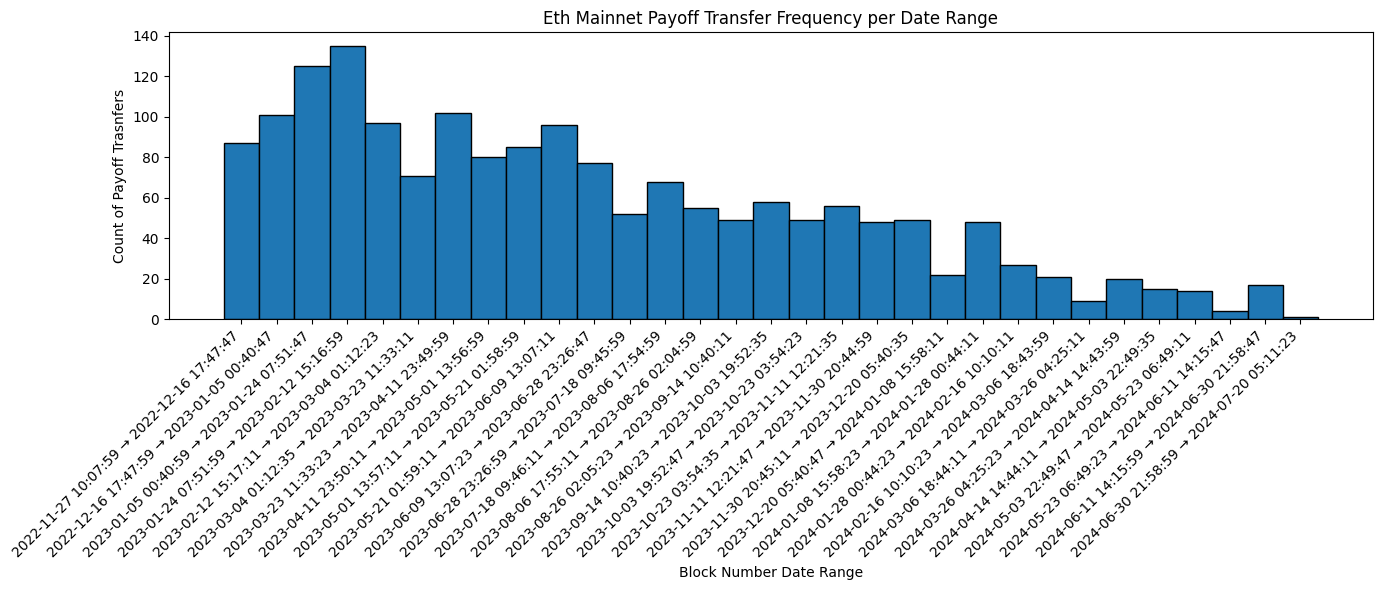

In [45]:
# Automatic bucket size (roughly 20 buckets)
num_buckets = 30
bucket_size = max(1, (max_block - min_block) // num_buckets)
bins = np.arange(min_block, max_block + bucket_size, bucket_size)

# Compute human-readable labels for each bin
bin_labels = [
    f"{datetime.utcfromtimestamp(start)} → {datetime.utcfromtimestamp(end)}"
    for start, end in (
        bucket_to_time_range(int(bins[i]), int(bins[i + 1] - 1), w3_eth)
        for i in range(len(bins) - 1)
    )
]

# Plot histogram
plt.figure(figsize=(14,6))
plt.hist(payoff_transfers_eth['block_number'], bins=bins, edgecolor='black')
plt.title("Eth Mainnet Payoff Transfer Frequency per Date Range")
plt.xlabel("Block Number Date Range")
plt.ylabel("Count of Payoff Trasnfers")
plt.xticks(ticks=bins[:-1] + bucket_size/2, labels=bin_labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()


## Ethereum attackers 

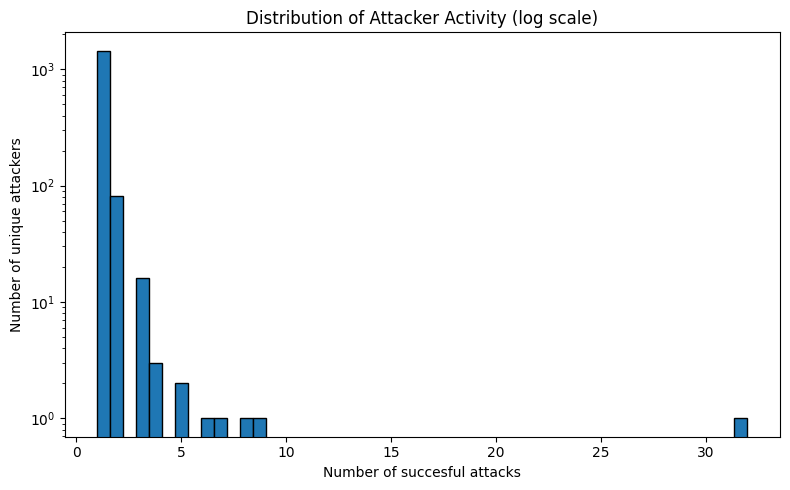

In [61]:
# Count how many times each attacker (topics_to_addr) appears
attacker_counts = payoff_transfers_eth['topics_to_addr'].value_counts()

# Plot histogram of those counts
plt.figure(figsize=(8, 5))
plt.hist(attacker_counts, bins=50, edgecolor='black', log=True)
plt.xlabel('Number of succesful attacks')
plt.ylabel('Number of unique attackers')
plt.title('Distribution of Attacker Activity (log scale)')
plt.tight_layout()
plt.show()


In [62]:
# Count how many times each attacker address appears
attacker_counts = payoff_transfers_eth['topics_to_addr'].value_counts()

# Get the top 10 attackers
top_attackers = attacker_counts.head(10)

# Print results
print("Top 10 attackers by number of occurrences:\n")
for rank, (address, count) in enumerate(top_attackers.items(), start=1):
    print(f"{rank}. {address} — {count} occurrences")

Top 10 attackers by number of occurrences:

1. 0xedEa5c9611ebA47998C9C245Bc0Eb212FC8A2DCe — 32 occurrences
2. 0xe5AB17098506A1Be492E948C9A9b3B7A9bD35DD5 — 9 occurrences
3. 0xdAA744760E4ad8C5C4773d1f84913d59Ea141855 — 8 occurrences
4. 0x23c22839503eF2165d75be41Ff17906b83CfBaBF — 7 occurrences
5. 0x946C8e51D95A1f1643c3617363aeE83439f98Cd6 — 6 occurrences
6. 0x95008eCb751EbC8C8a667f9D5688849CB74066a2 — 5 occurrences
7. 0xF689570e7e0D10A01844e94d612ab2562C402525 — 5 occurrences
8. 0x79396c1e60bf1aD60cDBc61e50589f460E21A251 — 4 occurrences
9. 0xf337A2A4C87C173ec625659Df2F2Ab749dEd265F — 4 occurrences
10. 0x03A84bE9ce3d8918f29A7B4653a8FcfB9Cc0483D — 4 occurrences


## Helper Functions & Definitions for Binance Analysis

In [56]:
BSC_RPC = "https://bsc-dataseed.binance.org/" 
w3_bsc = Web3(Web3.HTTPProvider(BSC_RPC))
w3_bsc.middleware_onion.inject(ExtraDataToPOAMiddleware, layer=0)
print("Connected:", w3_bsc.is_connected())
print("Chain ID:", w3_bsc.eth.chain_id)  # Should be 56 for BSC mainnet

Connected: True
Chain ID: 56


In [57]:
# Path to your CSV
BSC_PATH = "/Users/vlad/Downloads/GitHub/ethereum-poisoning-detector/data/payoff_transfers_bsc.csv"

# Read CSV
payoff_transfers_bsc = pd.read_csv(BSC_PATH)

# Ensure block_number is integer
payoff_transfers_bsc['block_number'] = payoff_transfers_bsc['block_number'].astype(int)

# Get min/max block numbers
min_block = int(payoff_transfers_bsc['block_number'].min())
max_block = int(payoff_transfers_bsc['block_number'].max())
print(f"min block height: {min_block}, max block height: {max_block}")
start_time, end_time = bucket_to_time_range(min_block, max_block, w3_bsc)
print(f"Blockheight date range: {datetime.utcfromtimestamp(start_time)} → {datetime.utcfromtimestamp(end_time)}")

min block height: 22853528, max block height: 40071926
Blockheight date range: 2022-11-07 15:19:58 → 2024-06-30 19:16:02


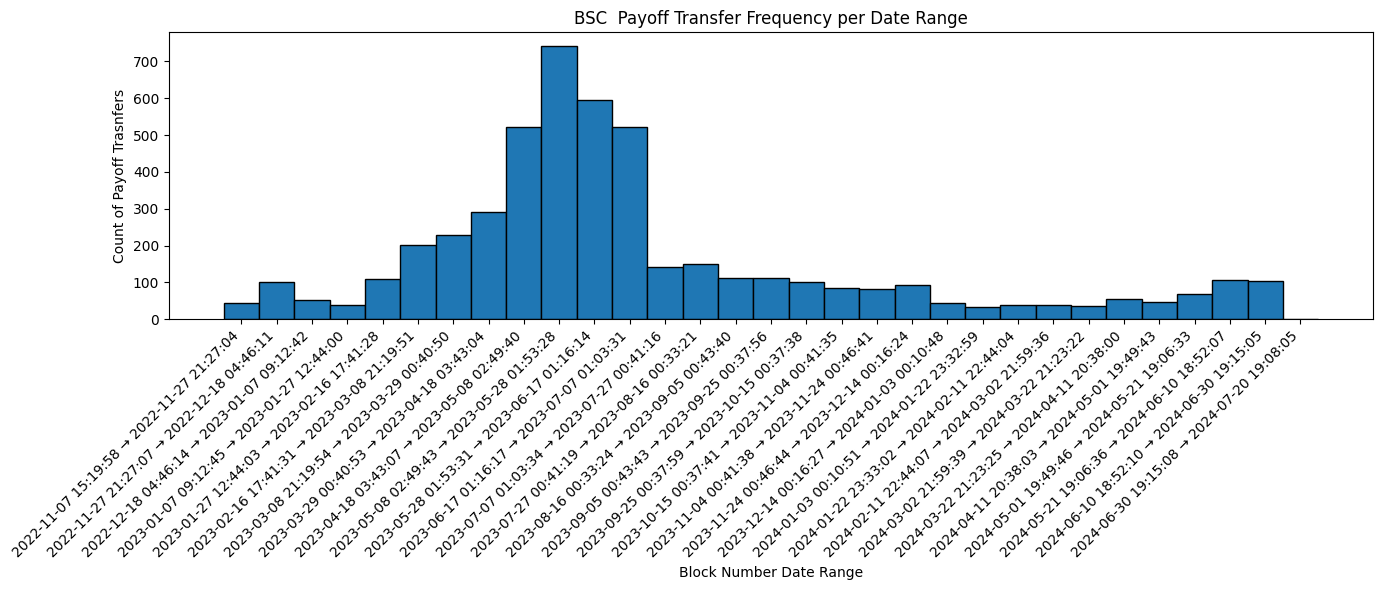

In [59]:
# Automatic bucket size (roughly 20 buckets)
num_buckets = 30
bucket_size = max(1, (max_block - min_block) // num_buckets)
bins = np.arange(min_block, max_block + bucket_size, bucket_size)

# Compute human-readable labels for each bin
bin_labels = [
    f"{datetime.utcfromtimestamp(start)} → {datetime.utcfromtimestamp(end)}"
    for start, end in (
        bucket_to_time_range(int(bins[i]), int(bins[i + 1] - 1), w3_bsc)
        for i in range(len(bins) - 1)
    )
]

# Plot histogram
plt.figure(figsize=(14,6))
plt.hist(payoff_transfers_bsc['block_number'], bins=bins, edgecolor='black')
plt.title("BSC  Payoff Transfer Frequency per Date Range")
plt.xlabel("Block Number Date Range")
plt.ylabel("Count of Payoff Trasnfers")
plt.xticks(ticks=bins[:-1] + bucket_size/2, labels=bin_labels, rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# save your PostgreSQL credentials in postgre.json file
try:
    with open("./postgre.json", "r", encoding="latin-1") as credential:
        json_credential = json.load(credential)

except FileNotFoundError:
    print("Please create a postgre.json file with your PostgreSQL credentials.")
    print("The file should contain the following keys: host, database, username, password.")
    print('{"host": "localhost", "database": "your_database_name", "username": "your_username", "password": "your_password"}')
    exit()

HOST = json_credential["host"]
DATABASE = json_credential["database"]
USERNAME = json_credential["username"]
PASSWORD = json_credential["password"]

# connect to your database
conn = psycopg2.connect(database=DATABASE, user=USERNAME, host="localhost", password=PASSWORD)
c = conn.cursor()
print('Successfully connected to the database')

db_name = json_credential["table"]

Successfully connected to the database


In [4]:
# new eth data
NEW_ETH_PATH = "/Users/vlad/Downloads/GitHub/ethereum-poisoning-detector/data/big-query-results.csv"

# Read CSV
raw_type_typosquat = pd.read_csv(NEW_ETH_PATH)

In [6]:
import pandas as pd

# Ensure 'amount' is numeric
raw_type_typosquat['amount'] = pd.to_numeric(raw_type_typosquat['amount'], errors='coerce')

# Filter out token addresses that never had a transfer with amount > 0
filtered_df = raw_type_typosquat.groupby('token_address').filter(lambda x: (x['amount'] > 0).any())

# Get unique token addresses from the filtered dataframe
unique_addresses = filtered_df['token_address'].unique().tolist()

# Print the list and its length
print("Number of unique token addresses with at least one transfer > 0:", len(unique_addresses))


Number of unique token addresses with at least one transfer > 0: 146


In [5]:
import requests

def get_labels_for_address(address: str):
    # Note: this is community-maintained data, not official Etherscan API
    url = f"https://octal.art/etherscan-labels/addresses/{address.lower()}.json"
    resp = requests.get(url)
    if resp.status_code == 200:
        return resp.json().get("Labels", {})
    else:
        return None

# Example usage:
addrs = unique_addresses
for addr in addrs:
    labels = get_labels_for_address(addr)
    print(addr, "=>", labels)


0x056fd409e1d7a124bd7017459dfea2f387b6d5cd => {'gemini': {'Name Tag': 'Gemini: GUSD Token', 'Description': 'Gemini\xa0a secure place to buy, sell, and store cryptocurrency', 'Token Name': 'Gemini dollar (GUSD)'}, 'stablecoin': {'Token Name': 'Gemini dollar (GUSD)'}}
0x57ab1ec28d129707052df4df418d58a2d46d5f51 => {'proxy-contract': {'Name Tag': 'Synthetix: Proxy sUSD Token', 'Description': 'A proxy contract\xa0acts as an eternal storage and will\xa0DELEGATECALL\xa0to the logic\xa0contract, which processes the data.'}, 'stablecoin': {'Token Name': 'Synth sUSD (sUSD)'}, 'synthetix': {'Name Tag': 'Synthetix: Proxy sUSD Token', 'Description': 'Synthetix, formerly Havven, is a cryptoasset-backed network that enables the creation of on-chain synthetic assets.', 'Subcategory': 'Main', 'Token Name': 'Synth sUSD (sUSD)'}}
0xc93a59888e7e6f2849ba94acf767266299c4c415 => None
0xa4bdb11dc0a2bec88d24a3aa1e6bb17201112ebe => {'stablecoin': {'Token Name': 'StableUSD (USDS)'}}
0x13ad2d31925490b0e282d51ac1a

In [11]:
# ===============================================================
#  FIXED VERSION – Works with goplus SDK object (no .get error)
# ===============================================================

import time
from typing import Dict, List, Optional
from goplus.token import Token

# ------------------------------------------------------------------
#  CONFIG
# ------------------------------------------------------------------
CHAIN_ID = "1"
REQUEST_DELAY = 1  # slightly safer for free tier

REAL_TOKENS = {
    "0xdac17f958d2ee523a2206206994597c13d831ec7": "USDT",
    "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48": "USDC"
}

# ------------------------------------------------------------------
#  Helper – correctly reads the SDK response object
# ------------------------------------------------------------------
def is_fake_usdt_usdc(result_obj) -> Optional[str]:
    if not result_obj:
        return None
    fake = getattr(result_obj, "fake_token", None)
    if fake and getattr(fake, "value", 0) == 1:
        true_addr = getattr(fake, "true_token_address", "").lower()
        if true_addr in REAL_TOKENS:
            return true_addr
    return None

# ------------------------------------------------------------------
#  Main loop – robust against SDK object type
# ------------------------------------------------------------------
client = Token(access_token=None)
fake_token_map: Dict[str, int] = {}
total = len(unique_addresses)

print(f"Starting analysis of {total} addresses (USDT/USDC fakes only)...\n")

fake_usdc = []
fake_usdt = []

for i, raw_addr in enumerate(unique_addresses, start=1):
    addr = raw_addr.strip().lower()
    if not addr.startswith("0x") or len(addr) != 42:
        print(f"[{i}/{total}] Invalid → {addr}")
        continue

    try:
        print(f"[{i}/{total}] {addr} ... ", end="")
        response = client.token_security(chain_id=CHAIN_ID, addresses=[addr])

        # Correct way: response.result is a dict-like with contract addresses as keys
        result_obj = response.result.get(addr) if response.result else None

        if not result_obj:
            print("no result")
            continue

        true_addr = is_fake_usdt_usdc(result_obj)
        if true_addr:
            if true_addr == '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48':
                fake_usdc.append(raw_addr)
            else:
                fake_usdt.append(raw_addr)
            name = REAL_TOKENS[true_addr]
            fake_token_map[true_addr] = fake_token_map.get(true_addr, 0) + 1
            print(f"FAKE {name}")
        else:
            print("clean")

    except Exception as e:
        print(f"ERROR → {type(e).__name__}: {e}")

    if i < total:
        time.sleep(REQUEST_DELAY)

# ------------------------------------------------------------------
#  Final result
# ------------------------------------------------------------------
total_fakes = sum(fake_token_map.values())

print("\n" + "="*70)
print("FINAL RESULTS – Fake USDT/USDC Clones")
print("="*70)
for true_addr, count in sorted(fake_token_map.items(), key=lambda x: x[1], reverse=True):
    print(f"{REAL_TOKENS[true_addr]:4} → {count} fake(s) | {true_addr}")
print("-"*70)
print(f"TOTAL FAKE CLONES FOUND: {total_fakes} out of {total} checked")
print("="*70)

# ← This is the variable you wanted
fake_token_map

Starting analysis of 146 addresses (USDT/USDC fakes only)...

[1/146] 0x056fd409e1d7a124bd7017459dfea2f387b6d5cd ... clean
[2/146] 0x57ab1ec28d129707052df4df418d58a2d46d5f51 ... clean
[3/146] 0xc93a59888e7e6f2849ba94acf767266299c4c415 ... FAKE USDC
[4/146] 0xa4bdb11dc0a2bec88d24a3aa1e6bb17201112ebe ... clean
[5/146] 0x13ad2d31925490b0e282d51ac1ae744f1da22c77 ... clean
[6/146] 0xe87cd66bfd18fd5b8e0a4089f69b237921eec33c ... FAKE USDC
[7/146] 0xcbd3cb376211d602be5bfbbb7cd06bc14cc77bb9 ... FAKE USDT
[8/146] 0xc5946f2a2b061f4ff8e49d63f0ea60d9fb4fc896 ... FAKE USDT
[9/146] 0xca21bc48227c149b49f762f7f6064e9dd3d85ad2 ... FAKE USDT
[10/146] 0x2cb6d9b8c39db1415fa2f5776a965999aee1cacd ... FAKE USDC
[11/146] 0xc076ac8a2afbbf69b0b1142c99d0b66170acee98 ... FAKE USDT
[12/146] 0xbfe2942c5e94e79dfe326cd6ddcf3d9ccb38d230 ... FAKE USDT
[13/146] 0x5e483a119d62d080ca01f63807c8e521b445dffe ... FAKE USDT
[14/146] 0x292e67fe392b811d486c81eceb25ea96af57c2fc ... clean
[15/146] 0x07d1d1d38b341d597ea6bb5ee198680c

{'0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48': 9,
 '0xdac17f958d2ee523a2206206994597c13d831ec7': 35}

In [ ]:
print("fake_usdt len", len(fake_usdt))
print("fake_usdc len", len(fake_usdc))

fake_usdt len 35
fake_usdc len 9


'0xc93a59888e7e6f2849ba94acf767266299c4c415'

In [15]:
result_pwned_usdt = filtered_df[filtered_df['token_address'].isin(fake_usdt)]
result_pwned_usdt

,block_timestamp,transaction_hash,token_address,symbol,name,from_address,to_address,amount
114,2025-07-01 09:28:35 UTC,0x9737166851100526c9e7bf86f9c79828e24f2e3289dc...,0xcbd3cb376211d602be5bfbbb7cd06bc14cc77bb9,USDT,Tether USD,0xa14839e0398d1c1942136ddfbe96d3d3095af25c,0x52466a1e5e2ff9cfea19c9e9e7e0272ec2f14c50,2.329836e+11
115,2025-07-01 10:06:35 UTC,0x019e76cdce0f18fb34a48f41e0539d1b050a558b95d2...,0xc5946f2a2b061f4ff8e49d63f0ea60d9fb4fc896,USDT,Tether,0x5247920b4a7e5ff5e21d0a2c00657c3c23fd6907,0xb280d64a703b4d2da0aa4898a1cd46bbe01f4e2b,2.341114e+11
135,2025-07-01 11:49:11 UTC,0xd986d66c0b4f205fc8a7484c53e46741aabcbfa16274...,0xc5946f2a2b061f4ff8e49d63f0ea60d9fb4fc896,USDT,Tether,0xb280d64a703b4d2da0aa4898a1cd46bbe01f4e2b,0x0115a021335231d7d247faa9f968ba55daf9c28f,2.917550e+09
138,2025-07-01 11:53:35 UTC,0x0cc6b3f0d4e4c45edadc6077d6f82033e63f5c8c7284...,0xca21bc48227c149b49f762f7f6064e9dd3d85ad2,USDT,Tether,0xe4061036e9471d1ae32eb01b059de9f0e01f9472,0x3f8d759bf1481a465682a1594272bfc9f513f7eb,6.156707e+10
223,2025-07-01 14:58:11 UTC,0x033624914dfb2e15f473a1e42c3746c32d636dbfb6ec...,0xc076ac8a2afbbf69b0b1142c99d0b66170acee98,USDT,USDT,0x26475c7dec1b82730b7aecedc31770094e3338ea,0x7e39d60ded9aaf1b2591941a03869a8ddd5353ce,7.534524e+22
...,...,...,...,...,...,...,...,...
62017,2025-10-31 17:41:11 UTC,0x23f4e2bb69ec88a1e1213f27329e46e0dbbdd4d5bb95...,0x5e483a119d62d080ca01f63807c8e521b445dffe,USDT,Tether USD,0x86dd04478aa1310e9daef1e7ce0617cb7d11e8f7,0xffeca790848f4990440058d2d700f62a30a67ce1,1.841400e+11
62024,2025-10-31 18:02:11 UTC,0x40a6ba71a601bde1e1b9bdf3a16286f53fec4dc18b35...,0xbfe2942c5e94e79dfe326cd6ddcf3d9ccb38d230,USDT,Tether,0x0ef48fb856a3b85c941862b62b68c931c48cac30,0xdb70da9c45ac9ab1d5764bfaa4c2ebc6d01ae743,5.815600e+10
62089,2025-10-31 22:02:11 UTC,0x04d8fa00428ffad4f2a9d26c01c464b52a444c7cac60...,0x5e483a119d62d080ca01f63807c8e521b445dffe,USDT,Tether USD,0x7e2370cb1755e2a2cd119a48f8f7411de4e31860,0x64597d421eaa3e47bdb1f0d7c41b8298622df24b,9.800000e+08
62098,2025-10-31 22:25:23 UTC,0x3e1da5aa836d5940860ed72db8238d0f49fc6d062af0...,0x5e483a119d62d080ca01f63807c8e521b445dffe,USDT,Tether USD,0x86dd04478aa1310e9daef1e7ce0617cb7d11e8f7,0x7e2370cb1755e2a2cd119a48f8f7411de4e31860,1.685600e+11


In [17]:
result_pwned_usdc = filtered_df[filtered_df['token_address'].isin(fake_usdc)]
result_pwned_usdc

,block_timestamp,transaction_hash,token_address,symbol,name,from_address,to_address,amount
28,2025-07-01 02:06:23 UTC,0x182d7779f4c83710edf4ee2b2659ce67279669b9ed76...,0xc93a59888e7e6f2849ba94acf767266299c4c415,USDC,USD CLASSIC,0x000000000004444c5dc75cb358380d2e3de08a90,0xa252d38c78d4250056d107ab8d255b2ebf1b7bc9,4.480635e+16
111,2025-07-01 09:00:35 UTC,0xf2de1a8c1b142799c63e3c47618181d9da3fcdc690d3...,0xe87cd66bfd18fd5b8e0a4089f69b237921eec33c,USDC,USD Coin,0x2e880be1afca6f0fc659ce67b75d5d79b55ffdb7,0xb6e6efa2d797c943b5f623994faa1574dcb00910,1.989714e+11
183,2025-07-01 12:14:23 UTC,0xe06cde0e58ecc4868278f57adcb2ec2e60898439bb13...,0x2cb6d9b8c39db1415fa2f5776a965999aee1cacd,USDC,USD Coin,0xb80baf20ca9fae232b4e94e187f8553266f2ccb8,0x5af0af2939beab41223d412e1d38610dc2c90050,6.213479e+10
201,2025-07-01 12:51:59 UTC,0x9d5a3369eb80c1a17e0f8386ae2c08275dd06763057f...,0xe87cd66bfd18fd5b8e0a4089f69b237921eec33c,USDC,USD Coin,0x2e880be1afca6f0fc659ce67b75d5d79b55ffdb7,0x66d971b1da1e006f48b291f43b4c7e3cc647d520,1.699841e+11
224,2025-07-01 15:06:47 UTC,0x8012d2787abd891e7fed150d034628aa7ad2b8deb1c2...,0x2cb6d9b8c39db1415fa2f5776a965999aee1cacd,USDC,USD Coin,0xb80baf20ca9fae232b4e94e187f8553266f2ccb8,0xf6119694d0ab998c7e813843f7b5f65c10e0412f,1.862856e+10
...,...,...,...,...,...,...,...,...
61400,2025-10-30 16:59:23 UTC,0x349e363cfd2ca57fabe7a0175f88f5b3524f54dd81fc...,0x2cb6d9b8c39db1415fa2f5776a965999aee1cacd,USDC,USD Coin,0x3df103edc7746c074aacc83e386e70ace6a1eb14,0xb80baf20ca9fae232b4e94e187f8553266f2ccb8,1.503659e+10
61665,2025-10-31 00:02:35 UTC,0xb2b42720761bfefc74475b365f5c9b69f07dcf93271c...,0xc93a59888e7e6f2849ba94acf767266299c4c415,USDC,USD CLASSIC,0x63242a4ea82847b20e506b63b0e2e2eff0cc6cb0,0x7844cd7b0a3d3dbe2b447e86925685c331b1b07a,3.000000e+16
61666,2025-10-31 00:02:35 UTC,0xb2b42720761bfefc74475b365f5c9b69f07dcf93271c...,0xc93a59888e7e6f2849ba94acf767266299c4c415,USDC,USD CLASSIC,0xa252d38c78d4250056d107ab8d255b2ebf1b7bc9,0x63242a4ea82847b20e506b63b0e2e2eff0cc6cb0,3.000000e+16
61949,2025-10-31 13:34:47 UTC,0x7dab189e1e930c87b03690d25e679a46671020f5839d...,0xe87cd66bfd18fd5b8e0a4089f69b237921eec33c,USDC,USD Coin,0x2e880be1afca6f0fc659ce67b75d5d79b55ffdb7,0x167f6a8624803e15865d0c6fa8142b3e97220625,2.759766e+10


In [22]:
pwnd_tokens = fake_usdc + fake_usdt 

result_pwned = filtered_df[filtered_df['token_address'].isin(pwnd_tokens)]
result_pwned

,block_timestamp,transaction_hash,token_address,symbol,name,from_address,to_address,amount
28,2025-07-01 02:06:23 UTC,0x182d7779f4c83710edf4ee2b2659ce67279669b9ed76...,0xc93a59888e7e6f2849ba94acf767266299c4c415,USDC,USD CLASSIC,0x000000000004444c5dc75cb358380d2e3de08a90,0xa252d38c78d4250056d107ab8d255b2ebf1b7bc9,4.480635e+16
111,2025-07-01 09:00:35 UTC,0xf2de1a8c1b142799c63e3c47618181d9da3fcdc690d3...,0xe87cd66bfd18fd5b8e0a4089f69b237921eec33c,USDC,USD Coin,0x2e880be1afca6f0fc659ce67b75d5d79b55ffdb7,0xb6e6efa2d797c943b5f623994faa1574dcb00910,1.989714e+11
114,2025-07-01 09:28:35 UTC,0x9737166851100526c9e7bf86f9c79828e24f2e3289dc...,0xcbd3cb376211d602be5bfbbb7cd06bc14cc77bb9,USDT,Tether USD,0xa14839e0398d1c1942136ddfbe96d3d3095af25c,0x52466a1e5e2ff9cfea19c9e9e7e0272ec2f14c50,2.329836e+11
115,2025-07-01 10:06:35 UTC,0x019e76cdce0f18fb34a48f41e0539d1b050a558b95d2...,0xc5946f2a2b061f4ff8e49d63f0ea60d9fb4fc896,USDT,Tether,0x5247920b4a7e5ff5e21d0a2c00657c3c23fd6907,0xb280d64a703b4d2da0aa4898a1cd46bbe01f4e2b,2.341114e+11
135,2025-07-01 11:49:11 UTC,0xd986d66c0b4f205fc8a7484c53e46741aabcbfa16274...,0xc5946f2a2b061f4ff8e49d63f0ea60d9fb4fc896,USDT,Tether,0xb280d64a703b4d2da0aa4898a1cd46bbe01f4e2b,0x0115a021335231d7d247faa9f968ba55daf9c28f,2.917550e+09
...,...,...,...,...,...,...,...,...
62017,2025-10-31 17:41:11 UTC,0x23f4e2bb69ec88a1e1213f27329e46e0dbbdd4d5bb95...,0x5e483a119d62d080ca01f63807c8e521b445dffe,USDT,Tether USD,0x86dd04478aa1310e9daef1e7ce0617cb7d11e8f7,0xffeca790848f4990440058d2d700f62a30a67ce1,1.841400e+11
62024,2025-10-31 18:02:11 UTC,0x40a6ba71a601bde1e1b9bdf3a16286f53fec4dc18b35...,0xbfe2942c5e94e79dfe326cd6ddcf3d9ccb38d230,USDT,Tether,0x0ef48fb856a3b85c941862b62b68c931c48cac30,0xdb70da9c45ac9ab1d5764bfaa4c2ebc6d01ae743,5.815600e+10
62089,2025-10-31 22:02:11 UTC,0x04d8fa00428ffad4f2a9d26c01c464b52a444c7cac60...,0x5e483a119d62d080ca01f63807c8e521b445dffe,USDT,Tether USD,0x7e2370cb1755e2a2cd119a48f8f7411de4e31860,0x64597d421eaa3e47bdb1f0d7c41b8298622df24b,9.800000e+08
62098,2025-10-31 22:25:23 UTC,0x3e1da5aa836d5940860ed72db8238d0f49fc6d062af0...,0x5e483a119d62d080ca01f63807c8e521b445dffe,USDT,Tether USD,0x86dd04478aa1310e9daef1e7ce0617cb7d11e8f7,0x7e2370cb1755e2a2cd119a48f8f7411de4e31860,1.685600e+11


In [37]:
# Filter: keep only rows where amount > 0.01
sanitized_df = result_pwned[result_pwned['amount'] > 0.1]
sanitized_df

,block_timestamp,transaction_hash,token_address,symbol,name,from_address,to_address,amount
28,2025-07-01 02:06:23 UTC,0x182d7779f4c83710edf4ee2b2659ce67279669b9ed76...,0xc93a59888e7e6f2849ba94acf767266299c4c415,USDC,USD CLASSIC,0x000000000004444c5dc75cb358380d2e3de08a90,0xa252d38c78d4250056d107ab8d255b2ebf1b7bc9,4.480635e+16
111,2025-07-01 09:00:35 UTC,0xf2de1a8c1b142799c63e3c47618181d9da3fcdc690d3...,0xe87cd66bfd18fd5b8e0a4089f69b237921eec33c,USDC,USD Coin,0x2e880be1afca6f0fc659ce67b75d5d79b55ffdb7,0xb6e6efa2d797c943b5f623994faa1574dcb00910,1.989714e+11
114,2025-07-01 09:28:35 UTC,0x9737166851100526c9e7bf86f9c79828e24f2e3289dc...,0xcbd3cb376211d602be5bfbbb7cd06bc14cc77bb9,USDT,Tether USD,0xa14839e0398d1c1942136ddfbe96d3d3095af25c,0x52466a1e5e2ff9cfea19c9e9e7e0272ec2f14c50,2.329836e+11
115,2025-07-01 10:06:35 UTC,0x019e76cdce0f18fb34a48f41e0539d1b050a558b95d2...,0xc5946f2a2b061f4ff8e49d63f0ea60d9fb4fc896,USDT,Tether,0x5247920b4a7e5ff5e21d0a2c00657c3c23fd6907,0xb280d64a703b4d2da0aa4898a1cd46bbe01f4e2b,2.341114e+11
135,2025-07-01 11:49:11 UTC,0xd986d66c0b4f205fc8a7484c53e46741aabcbfa16274...,0xc5946f2a2b061f4ff8e49d63f0ea60d9fb4fc896,USDT,Tether,0xb280d64a703b4d2da0aa4898a1cd46bbe01f4e2b,0x0115a021335231d7d247faa9f968ba55daf9c28f,2.917550e+09
...,...,...,...,...,...,...,...,...
62017,2025-10-31 17:41:11 UTC,0x23f4e2bb69ec88a1e1213f27329e46e0dbbdd4d5bb95...,0x5e483a119d62d080ca01f63807c8e521b445dffe,USDT,Tether USD,0x86dd04478aa1310e9daef1e7ce0617cb7d11e8f7,0xffeca790848f4990440058d2d700f62a30a67ce1,1.841400e+11
62024,2025-10-31 18:02:11 UTC,0x40a6ba71a601bde1e1b9bdf3a16286f53fec4dc18b35...,0xbfe2942c5e94e79dfe326cd6ddcf3d9ccb38d230,USDT,Tether,0x0ef48fb856a3b85c941862b62b68c931c48cac30,0xdb70da9c45ac9ab1d5764bfaa4c2ebc6d01ae743,5.815600e+10
62089,2025-10-31 22:02:11 UTC,0x04d8fa00428ffad4f2a9d26c01c464b52a444c7cac60...,0x5e483a119d62d080ca01f63807c8e521b445dffe,USDT,Tether USD,0x7e2370cb1755e2a2cd119a48f8f7411de4e31860,0x64597d421eaa3e47bdb1f0d7c41b8298622df24b,9.800000e+08
62098,2025-10-31 22:25:23 UTC,0x3e1da5aa836d5940860ed72db8238d0f49fc6d062af0...,0x5e483a119d62d080ca01f63807c8e521b445dffe,USDT,Tether USD,0x86dd04478aa1310e9daef1e7ce0617cb7d11e8f7,0x7e2370cb1755e2a2cd119a48f8f7411de4e31860,1.685600e+11


In [27]:
sanitized_df['amount'].mean()

np.float64(2.8123569479131035e+25)

/var/folders/1p/z01wly996kqgbn5g072fv5pw0000gn/T/ipykernel_13510/3715456985.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df[timestamp_col] = pd.to_datetime(
/var/folders/1p/z01wly996kqgbn5g072fv5pw0000gn/T/ipykernel_13510/3715456985.py:23: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  ts_seconds = output_df[timestamp_col].view('int64') // 10**9   # pandas datetime → ns → s


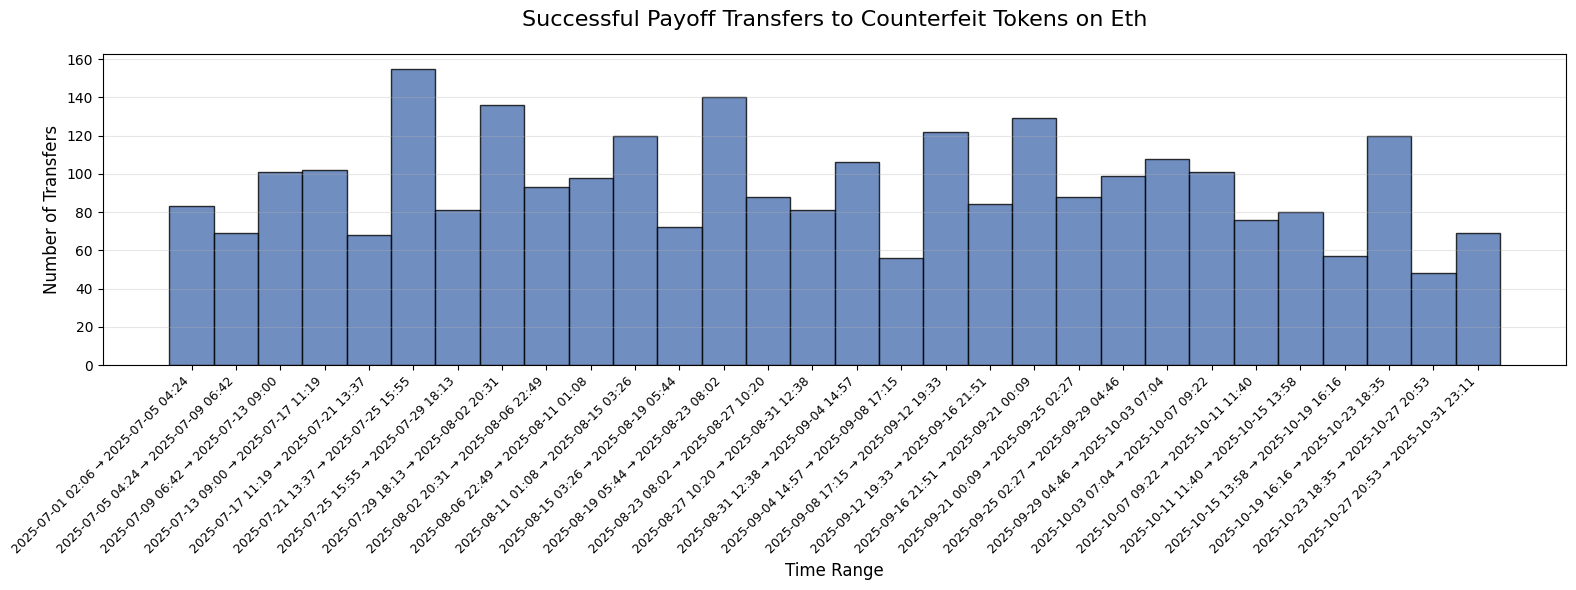

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime

# --------------------------------------------------------------
# CONFIG
# --------------------------------------------------------------
timestamp_col = 'block_timestamp'   # your column name
num_buckets   = 30                  # change if you want more/less bars

# --------------------------------------------------------------
# 1. Convert the string timestamps → pandas datetime → Unix seconds
# --------------------------------------------------------------
# Force UTC and drop any timezone info that might be attached
output_df = sanitized_df
output_df[timestamp_col] = pd.to_datetime(
    output_df[timestamp_col].str.replace(' UTC', '', regex=False),  # strip " UTC"
    utc=True
)

# Convert to seconds since epoch (int) – needed for numeric binning
ts_seconds = output_df[timestamp_col].view('int64') // 10**9   # pandas datetime → ns → s

# --------------------------------------------------------------
# 2. Build automatic buckets
# --------------------------------------------------------------
min_ts = ts_seconds.min()
max_ts = ts_seconds.max()

bucket_size = max(1, (max_ts - min_ts) // num_buckets)
bins = np.arange(min_ts, max_ts + bucket_size, bucket_size)   # in seconds

# --------------------------------------------------------------
# 3. Human-readable bin labels
# --------------------------------------------------------------
def sec_to_str(sec):
    return datetime.utcfromtimestamp(sec).strftime('%Y-%m-%d %H:%M')

bin_labels = [
    f"{sec_to_str(int(bins[i]))} → {sec_to_str(int(bins[i+1] - 1))}"
    for i in range(len(bins) - 1)
]

# --------------------------------------------------------------
# 4. Plot
# --------------------------------------------------------------
plt.figure(figsize=(16, 6))
counts, _, _ = plt.hist(ts_seconds, bins=bins,
                        edgecolor='black', color='#4c72b0', alpha=0.8)

plt.title("Successful Payoff Transfers to Counterfeit Tokens on Eth", fontsize=16, pad=20)
plt.xlabel("Time Range", fontsize=12)
plt.ylabel("Number of Transfers", fontsize=12)

# Center tick marks inside each bar
plt.xticks(
    ticks=bins[:-1] + bucket_size / 2,
    labels=bin_labels,
    rotation=45,
    ha='right',
    fontsize=9
)

plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Dataset (address_poisoning_ethereum)
Each data entry corresponds to one of token transfers related to address poisoning on Ethereum: intended, tiny, zero-value, counterfeit token, and payoff transfers.
The description and the type of each column is in the table below.

| Column | Type | Description |
|--------|------|-------------|
| block_number | integer | The block number of the transfer |
| tx_hash | character(66) | The transaction hash of the transfer |
| addr | character(42) | The address of the token transferred |
| topics_from_addr | character(42) | The sender |
| topics_to_addr | character(42) | The receiver |
| is_sender_victim | boolean | True if the sender is a victim |
| value | real | The value transferred |
| value_usd | real | The value converted to USD at the time of the transfer |
| intended_transfer | boolean | True if the transfer is an intended transfer |
| tiny_transfer | boolean | True if the transfer is a tiny transfer |
| zero_value_transfer | boolean | True if the transfer is a zero-value transfer |
| counterfeit_token_transfer | boolean | True if the transfer is a counterfeit token transfer |
| payoff_transfer | boolean | True if the transfer is a payoff transfer (confirmed) |
| payoff_transfer_unconfirmed | boolean | True if the transfer is potentially a payoff transfer (more investigation required) |
| is_not_categorized | boolean | True if the transfer is not labeled for any categories |
| intended_addr | character(42) | The intended address of the transfer |
| num_first_matched_digits | integer | The number of first matched digits |
| num_last_matched_digits | integer | The number of last matched digits |

Remarks
- `payoff_transfer` does not represent all the payoff transfers we captured. We confirm each transfer in `payoff_transfer_unconfirmed` on Etherscan to check if the poisoning transfer exists between the intended and the payoff transfer. Alternatively, you can find the final results in `payoff_transfers_ethereum.csv`.
- Most of the uncategorized transfers (is_not_categorized transfers=True) are tiny transfers that exceed the threshold (>=10 USD). There are only 8,651 out of 34,905,969 (0.025%).
- The number of matched first (last) digits is the number of matched digits between the lookalike address and the intended address. For the intended transfer, it would be (20, 20).

In [ ]:
# basic connection
conn.rollback()         # clear the aborted transaction
c.execute(f"SELECT * FROM {db_name} LIMIT 10;")
results = c.fetchall()
print(results[5])


(16582469, '0x31042594fce5088cfbdbc8b2e56f52a53cf9422f69552dd26eac02f3d702d8e4', '0xdAC17F958D2ee523a2206206994597C13D831ec7', '0xBC952257C0469125C6328A1d39d785805dc6849d', '0x61e0675505c5af10aE335E73C14aAA0f455Ee382', True, 16093270.0, 16.09327, True, False, False, False, False, False, False, '0x61e0675505c5af10aE335E73C14aAA0f455Ee382', 20, 20)
